In [1]:
# Canonical way of importing TensorFlow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits= load_digits()

# If this doesn't work TensorFlow is not installed correctly

# Check tf version, oftentimes tensorflow is not backwards compatible
tf.__version__

'1.4.0'

In [2]:
# TensorBoard Graph visualizer in notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
#     idx = np.arange(0, data.get_shape().as_list()[0])
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [4]:
# Break up data into train and test
from sklearn.model_selection import train_test_split

digits_target = []
for target in digits.target:
    a = np.zeros(10)
    a[target]=1
    digits_target.append(a.tolist())
    
    
# print (digits_target)
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits_target, test_size=0.20, random_state=0)
X_train, X_test, y_train2, y_test2 = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)


In [5]:
# Define hyperparameters and input size

n_inputs = 8*8  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [6]:
# Reset graph
tf.reset_default_graph()

In [7]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [8]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    epsilon = 1e-3
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        batch_mean, batch_var = tf.nn.moments(Z,[0])
        scale = tf.Variable(tf.ones([n_neurons]))
        beta = tf.Variable(tf.zeros([n_neurons]))
        BN = tf.nn.batch_normalization(Z,batch_mean,batch_var,beta,scale,epsilon)
        if activation is not None:
            return activation(BN), BN
        else:
            return Z

In [9]:
# Define the hidden layers
keep_prob = 0.9
with tf.name_scope("dnn"):
    hidden1, h1z = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.tanh)
    drop_out1 = tf.nn.dropout(hidden1, keep_prob)
    
    hidden2, h2z = neuron_layer(drop_out1, n_hidden2, name="hidden2",
                           activation=tf.nn.tanh)
    drop_out2 = tf.nn.dropout(hidden2, keep_prob)
    
    hidden3, h3z = neuron_layer(drop_out2, n_hidden3, name="hidden3",
                           activation=tf.nn.tanh)
    drop_out3 = tf.nn.dropout(hidden3, keep_prob)
    
    logits = neuron_layer(drop_out3, n_outputs, name="outputs")

In [10]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [11]:
# Training step with Gradient Descent

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [12]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
show_graph(tf.get_default_graph())

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 1001
batch_size = 100

epoch_arr = []
acc_tr_arr = []
acc_v_arr = []

# print(h1z, h2z, h3z)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         
        for i in range(len(x_train)//batch_size):
            batch_xs, batch_ys = next_batch(batch_size, X_train, y_train2)
            sess.run(training_op, feed_dict={X: batch_xs, y: batch_ys})
#             batch_mean1, batch_var1 = tf.nn.moments(h1z,[0])
#             batch_mean2, batch_var2 = tf.nn.moments(h2z,[0])
#             batch_mean3, batch_var3 = tf.nn.moments(h3z,[0])
        
        if epoch % 50 is 0:
            acc_train = accuracy.eval(feed_dict={X: batch_xs, y: batch_ys})
            acc_val = accuracy.eval(feed_dict={X: X_test,
                                            y: y_test2})
        
            print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
            epoch_arr.append(epoch)
            acc_tr_arr.append(acc_train)
            acc_v_arr.append(acc_val)

    save_path = saver.save(sess, "./my_model2_final.ckpt") # save model

0 Train accuracy: 0.1 Val accuracy: 0.0638889
50 Train accuracy: 0.82 Val accuracy: 0.775
100 Train accuracy: 0.89 Val accuracy: 0.869444
150 Train accuracy: 0.91 Val accuracy: 0.891667
200 Train accuracy: 0.93 Val accuracy: 0.902778
250 Train accuracy: 0.97 Val accuracy: 0.927778
300 Train accuracy: 0.95 Val accuracy: 0.927778
350 Train accuracy: 0.95 Val accuracy: 0.933333
400 Train accuracy: 0.97 Val accuracy: 0.933333
450 Train accuracy: 0.96 Val accuracy: 0.938889
500 Train accuracy: 0.95 Val accuracy: 0.958333
550 Train accuracy: 0.95 Val accuracy: 0.952778
600 Train accuracy: 0.95 Val accuracy: 0.938889
650 Train accuracy: 0.94 Val accuracy: 0.952778
700 Train accuracy: 0.98 Val accuracy: 0.961111
750 Train accuracy: 0.97 Val accuracy: 0.95
800 Train accuracy: 1.0 Val accuracy: 0.963889
850 Train accuracy: 0.96 Val accuracy: 0.955556
900 Train accuracy: 1.0 Val accuracy: 0.958333
950 Train accuracy: 0.99 Val accuracy: 0.952778
1000 Train accuracy: 0.98 Val accuracy: 0.952778


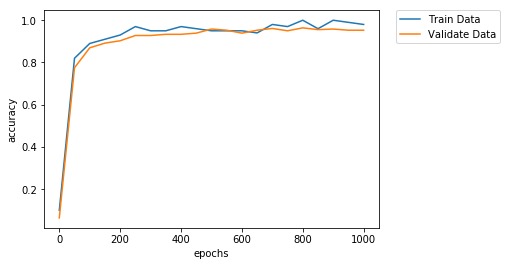

In [15]:
plt.plot(epoch_arr, acc_tr_arr, label="Train Data")
plt.plot(epoch_arr, acc_v_arr, label="Validate Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()